## Optimization Project 3 - Non Linear Programming

- Julian Lu
- Muskan Khepar
- Shruthi Chembu Kuppuswamy
- Keenan Hui

In [ ]:
!pip install gurobipy

In [ ]:
# Imports

from gurobipy import GRB
import gurobipy as gp
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

## 1) Linear Regression Model
Data on price and demand are included in the assignment. Fit a linear regression model to this data set.

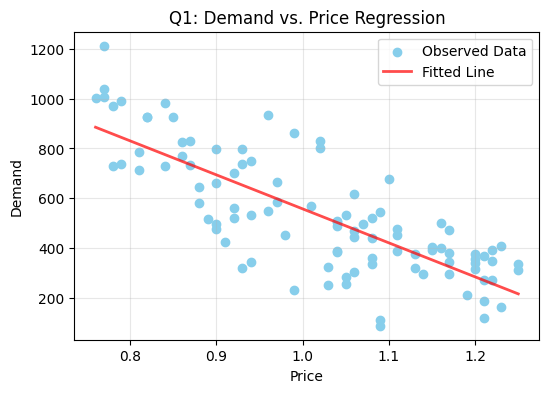


Regression equation: D = 1924.72 - 1367.71*p
R-squared: 0.621


In [ ]:
df = pd.read_csv('price_demand_data.csv')

# linear regression
X = sm.add_constant(df['price'])
model = sm.OLS(df['demand'], X).fit()

b0 = model.params["const"]
b1 = model.params["price"]

# plot regression fit
plt.figure(figsize=(6,4))
plt.scatter(df["price"], df["demand"], color="skyblue", label="Observed Data")
x_line = np.linspace(min(df["price"]), max(df["price"]), 100)
y_line = b0 + b1 * x_line
plt.plot(x_line, y_line, color="red", linewidth=2, label="Fitted Line", alpha=0.7)

plt.title("Q1: Demand vs. Price Regression")
plt.xlabel("Price")
plt.ylabel("Demand")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("\nRegression equation: D = {:.2f} - {:.2f}*p".format(b0, -b1))
print("R-squared:", round(model.rsquared, 3))


## 2) Get Demand Data
Let c=0.5, g=0.75, and t=0.15. Using the residuals, assume the price is p=1 and generate
demand data.




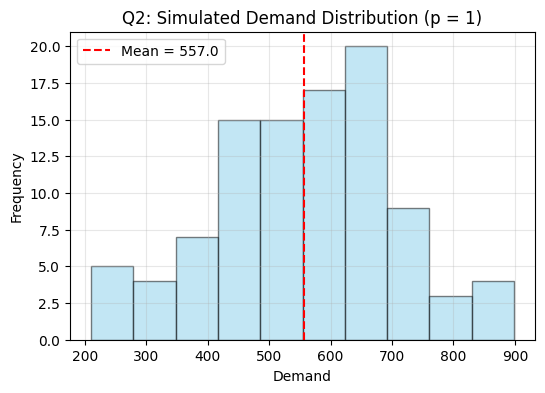

Simulated demand values (p=1): [351.39 579.52 472.22 448.94 673.75 453.13 430.1  480.87 554.2  720.84
 449.58 262.94 617.83 653.2  569.9  623.97 224.26 385.06 544.71 690.9
 593.58 634.52 522.23 703.51 471.87 722.43 216.32 299.91 828.35 693.43
 290.03 339.23 652.93 631.42 848.32 660.23 643.26 678.81 597.16 409.58
 647.9  719.83 547.42 527.13 485.48 588.54 495.29 610.51 583.68 539.45
 700.06 557.22 700.26 647.54 445.42 560.71 233.09 467.42 723.57 878.29
 593.74 438.71 575.51 422.65 512.17 210.09 701.78 478.57 543.97 614.54
 678.81 668.09 552.8  815.77 610.16 762.17 527.06 667.94 898.43 417.87
 654.22 551.06 529.51 628.54 406.22 675.93 561.71 363.03 359.23 451.78
 324.39 367.55 626.45 600.39 498.8  669.1  441.71 858.35 601.45]
Mean demand: 557.01


In [ ]:
# parameters
p = 1.0
c = 0.5
g = 0.75
t = 0.15

# get residuals and compute new demand for p = 1
residuals = model.resid.values
D = b0 + b1 * p + residuals

# plot the demand
plt.figure(figsize=(6,4))
plt.hist(D, bins=10, color="skyblue", edgecolor="black", alpha=0.5)
plt.axvline(np.mean(D), color="red", linestyle="--", label=f"Mean = {np.mean(D):.1f}")
plt.title("Q2: Simulated Demand Distribution (p = 1)")
plt.xlabel("Demand")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("Simulated demand values (p=1):", np.round(D,2))
print("Mean demand:", np.mean(D).round(2))


## 3) Solve Model
Solve the optimal quantity to produce when p=1. This is not quadratic at all, just an LP.

Objective:

$$
\max_{q} \; \frac{1}{n} \sum_{i=1}^{n}
\Big[\, p D_i - q c - g (D_i - q)^{+} - t (q - D_i)^{+} \,\Big]
$$

In [ ]:
n = len(D)
m = gp.Model("newsvendor_q_only")
m.setParam('OutputFlag', 0)

q = m.addVar(lb=0, name="q")
h = m.addVars(n, lb=-GRB.INFINITY, name="h")
dplus = m.addVars(n, lb=0, name="dplus")
excess = m.addVars(n, lb=0, name="excess")

# Constraints
for i in range(n):
    m.addConstr(dplus[i] >= D[i] - q)
    m.addConstr(excess[i] >= q - D[i])
    m.addConstr(h[i] == p*D[i] - q*c - g*dplus[i] - t*excess[i]) #Profit for each observation

m.setObjective((1/n) * gp.quicksum(h[i] for i in range(n)), GRB.MAXIMIZE)
m.optimize()

q_opt = q.X
profit_opt = m.ObjVal

print(f"Optimal q* = {q_opt:.2f}")
print(f"Expected average profit = {profit_opt:.2f}")

Optimal q* = 471.87
Expected average profit = 231.48


### Plot of profit as a function of 'q'

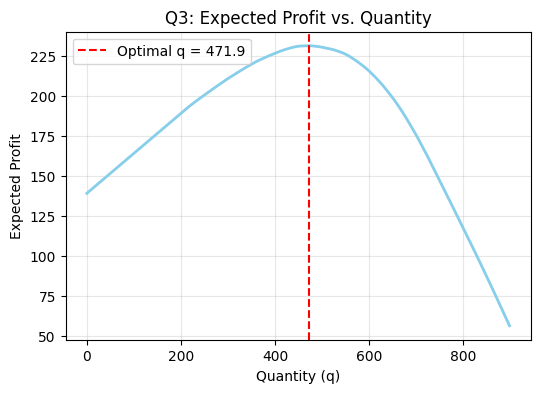

In [ ]:
q_vals = np.linspace(0, max(D), 300)
profits = []
for qv in q_vals:
    daily = p*D - qv*c - g*np.maximum(D - qv, 0) - t*np.maximum(qv - D, 0)
    profits.append(np.mean(daily))

plt.figure(figsize=(6,4))
plt.plot(q_vals, profits, color="skyblue", linewidth=2)
plt.axvline(q_opt, color="red", linestyle="--", label=f"Optimal q = {q_opt:.1f}")
plt.title("Q3: Expected Profit vs. Quantity")
plt.xlabel("Quantity (q)")
plt.ylabel("Expected Profit")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## 4) QP Formulation (Variable Price & Quantity)

### Objective Function

In Part 4, both price $p$ and quantity $q$ are decision variables. Demand is now a linear function of price: $D_i = \beta_0 + \beta_1 p + \epsilon_i$.

The objective function remains the same, but we substitute the new definition of $D_i$:
$$\max_{p, q}\frac{1}{n}\sum_{i=1}^{n}\Big(pD_{i}-qc-g(D_{i}-q)^{+}-t(q-D_{i})^{+}\Big)$$

The revenue term $pD_i$ becomes $p(\beta_0 + \beta_1 p + \epsilon_i) = \beta_0 p + \beta_1 p^2 + \epsilon_i p$. This **$p^2$** term makes our objective quadratic.

### QP Reformulation

As suggested in the project description, we will formulate this as a Quadratic Program (QP), which has a quadratic objective and linear constraints.

We split the profit "Profit = Revenue - Cost" and define a new variable $h_i$ to represent the negative cost for day $i$. This is different from the $h_i$ in Part 3 which is the entire profit for each day.

Here, maximizing negative costs is same as minimizing costs. Upper bound constraints shoud be added for $h_i$ instead of lower bound, and since cost is always positive, we can set upperbound to 0.

The objective function is then to maximize the sum of average revenue and average negative cost:
$$\max_{p, q, h} \; \left( \frac{1}{n} \sum_{i=1}^{n} pD_i \right) + \left( \frac{1}{n} \sum_{i=1}^{n} h_i \right)$$

Looking at the two terms here individually:
- **Average revenue:** The first term is the average revenue, which is basically the average value of $p(\beta_0 + \beta_1 p + \epsilon_i)$.
- **Average negative cost:** The second term is the average of negative costs, where cost is defined as:
$$h_i = -(\text{Cost}) = -qc - g(D_i - q)^{+} - t(q - D_i)^{+}$$


In [ ]:

# Getting all the parameters from previous steps
# b0, b1 are from the regression
# c, g, t are the costs
# residuals are from the regression
n = len(residuals)

# Create a new model
m_qp = gp.Model("newsvendor_qp")
m_qp.setParam('OutputFlag', 0) # Suppress Gurobi output

# Defining decision variables
p = m_qp.addVar(lb=0.0, name="price")
q = m_qp.addVar(lb=0.0, name="quantity")

# h_i represents the negative cost for each day i
# Set upper bound to 0, since costs are always postive
h = m_qp.addVars(n, lb=-GRB.INFINITY, ub=0.0, name="neg_cost")

# Setting quadratic objective function
# The objective is to maximize: (Average Revenue) + (Average Negative Cost)

# As explained in markdown above, average revenue = (1/n)*sum(p*(b0 + b1*p + residuals[i]))
avg_revenue = (1/n) * gp.quicksum(p * (b0 + b1*p + residuals[i]) for i in range(n))

# Average Negative Cost
avg_neg_cost = (1/n) * gp.quicksum(h[i] for i in range(n))

# Set the full objective
m_qp.setObjective(avg_revenue + avg_neg_cost, GRB.MAXIMIZE)

For adding the linear constraints, lets take the two cases, where we are producing more than demand, and less than demand:

1.  **Case 1: Shortage ($D_i > q$)**
    * The cost is: $\text{Cost} = qc + g(D_i - q)$.
    * The negative cost is: $h_i \le -[qc + g(D_i - q)] \implies h_i \le q(g-c) - gD_i$.
    * Substituting $D_i = \beta_0 + \beta_1 p + \epsilon_i \implies h_i \le q(g-c) - g(\beta_0 + \beta_1 p + \epsilon_i) \implies h_i \le q(g-c) - g\beta_1 p - g\beta_0 - g\epsilon_i$
    * This constraint is linear in $p$, $q$, and $h_i$.

2.  **Case 2: Surplus ($D_i \le q$)**
    * The cost is: $\text{Cost} = qc + t(q - D_i)$.
    * The negative cost is: $h_i \le -[qc + t(q - D_i)] \implies h_i \le -q(c+t) + tD_i$.
    * Substituting $D_i = \beta_0 + \beta_1 p + \epsilon_i \implies h_i \le -q(c+t) + t(\beta_0 + \beta_1 p + \epsilon_i) \implies h_i \le -q(c+t) + t\beta_1 p + t\beta_0 + t\epsilon_i$
    * This constraint is also linear in $p$, $q$, and $h_i$.

By adding these two linear constraints for each $i$, we force $h_i$ to be the correct negative cost.

In [ ]:
# Adding Linear Constraints
# We need to constrain h[i] to be the (negative) cost.
# Substitute D[i] = b0 + b1*p + residuals[i] into the constraints
for i in range(n):
    eps_i = residuals[i]

    # Constraint for the shortage case: h_i <= q(g-c) - g*D_i
    m_qp.addConstr(
        h[i] <= q*(g-c) - g*b1*p - g*b0 - g*eps_i,
        name=f"neg_cost_short_{i}"
    )

    # Constraint for the surplus case: h_i <= -q(c+t) + t*D_i
    m_qp.addConstr(
        h[i] <= -q*(c+t) + t*b1*p + t*b0 + t*eps_i,
        name=f"neg_cost_surplus_{i}"
    )

# Optimize and Get Results
m_qp.optimize()

print("Quadratic Programming Results (QP):")
if m_qp.Status == GRB.OPTIMAL:
    p_opt_qp = p.X
    q_opt_qp = q.X
    profit_opt_qp = m_qp.ObjVal

    print(f"Optimal Price (p*) = {p_opt_qp:.4f}")
    print(f"Optimal Quantity (q*) = {q_opt_qp:.4f}")
    print(f"Expected Average Profit = {profit_opt_qp:.4f}")
else:
    print("Optimization was not successful.")

Quadratic Programming Results (QP):
Optimal Price (p*) = 0.9536
Optimal Quantity (q*) = 535.2910
Expected Average Profit = 234.4249


### Profit Landscape Visualization

This graph provides a visual confirmation of the optimal solution found by the Quadratic Program (QP) model. It is a 2D contour plot showing the "profit landscape" based on our two decision variables: Price (p) and Quantity (q).

* **X-Axis (Price):** Represents the different sale prices ($p$) we could choose.
* **Y-Axis (Quantity):** Represents the different production quantities ($q$) we could choose.
* **Colors & Contours (Z-Axis):** Represent the Expected Average Profit in dollars at each specific $(p, q)$ coordinate. This profit was calculated by simulating the average profit over all $n$ demand residuals for every single point on the grid. Brighter areas (e.g., yellow) represent higher profit, while darker areas (e.g., purple) represent lower profit.


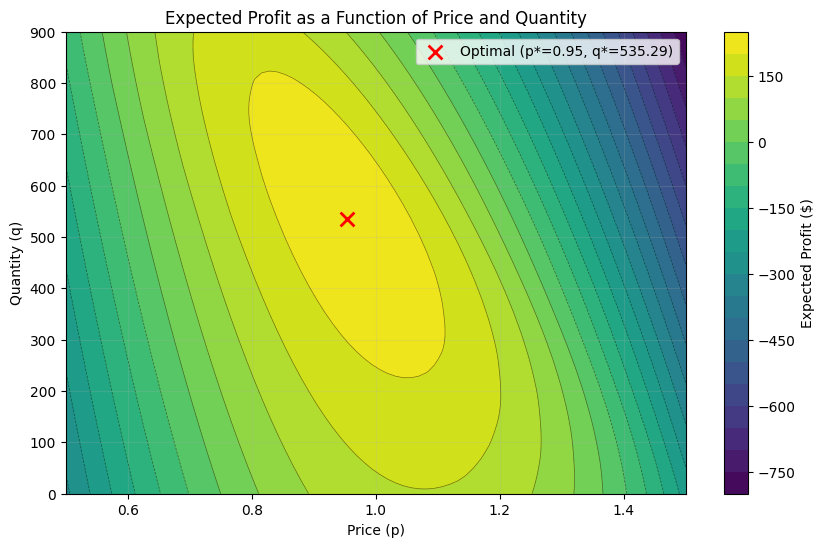

In [ ]:

# Define the grid to search
# Create a range of prices and quantities to plot
# Adjust these ranges if your optimal point is near the edge
p_vals = np.linspace(0.5, 1.5, 80)  # 80 price points
q_vals = np.linspace(0, 900, 80)    # 80 quantity points

# Create the 2D grid
P, Q = np.meshgrid(p_vals, q_vals)

# Initialize a grid to store profits
Z_profits = np.zeros(P.shape)

# Calculate profit for every (p, q) combination
for i in range(P.shape[0]):
    for j in range(P.shape[1]):
        # Get the p and q for this grid cell
        p_val = P[i, j]
        q_val = Q[i, j]

        # Calculate the vector of demands for this p_val
        D_sim = b0 + b1*p_val + residuals

        # Calculate the profit for all n scenarios
        daily_profits = (p_val * D_sim - q_val * c -
                         g * np.maximum(D_sim - q_val, 0) -
                         t * np.maximum(q_val - D_sim, 0))

        # Store the average profit
        Z_profits[i, j] = np.mean(daily_profits)

# Plot the contour map
plt.figure(figsize=(10, 6))

# Plot the colored-in contours
cp = plt.contourf(P, Q, Z_profits, levels=20, cmap='viridis')
plt.colorbar(cp, label='Expected Profit ($)')

# Add line contours to make it clearer
plt.contour(P, Q, Z_profits, levels=20, colors='black', linewidths=0.5, alpha=0.5)

# Plot the optimal point found by Gurobi
plt.scatter(p_opt_qp, q_opt_qp,
            color='red',
            marker='x',
            s=100,
            linewidth=2,
            label=f'Optimal (p*={p_opt_qp:.2f}, q*={q_opt_qp:.2f})')

plt.title('Expected Profit as a Function of Price and Quantity')
plt.xlabel('Price (p)')
plt.ylabel('Quantity (q)')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

- The plot clearly shows a single peak, which indicates that there is a single combination of price and quantity that maximizes profit. The concave shape is exactly what we would expect from the quadratic objective function we formulated.
- The Red 'X' is plotted at the exact $(p^*, q^*)$ coordinate pair that our Gurobi QP solver found to be optimal.
- The Red 'X' from Gurobi lands precisely on the peak of the simulated profit function. It confirms that our mathematical model (the QP formulation) and the brute-force simulation (used to generate this plot) are in agreement.

### 6.  We are now interested to know how sensitive the optimal price and quantity are to our data set. Take a bootstrap sample of the original dataset. Go back and fit new beta’s to the new bootstrapped dataset and redo step 4. Find the optimal price and quantity.

In [ ]:
# Step 6. Performs bootstrap via bootstrap_optimization function

def bootstrap_optimization(price_data, demand_data, c, g, t, n_bootstrap=1000, random_seed=None):
    """
    Perform bootstrap sampling and optimization

    Parameters:
    - price_data: original price data
    - demand_data: original demand data
    - c, g, t: cost parameters
    - n_bootstrap: number of bootstrap iterations
    - random_seed: random seed for reproducibility (default: None)

    Returns:
    - results dictionary with optimal prices, quantities, and profits
    """

    n_samples = len(price_data)

    if random_seed is not None:
      np.random.seed(random_seed)

    # Storage for results
    optimal_prices = []
    optimal_quantities = []
    optimal_profits = []

    for boot_iter in range(n_bootstrap):
        # Bootstrap sample (sample with replacement)
        boot_indices = np.random.choice(n_samples, size=n_samples, replace=True)
        boot_price = price_data[boot_indices]
        boot_demand = demand_data[boot_indices]

        # Fit new regression to bootstrapped data using statsmodels
        X_boot = sm.add_constant(boot_price)  # Add intercept
        model_boot = sm.OLS(boot_demand, X_boot)
        results_boot = model_boot.fit()

        # Extract coefficients
        boot_b0 = results_boot.params[0]  # Intercept
        boot_b1 = results_boot.params[1]  # Slope

        # Calculate residuals for bootstrapped sample
        boot_predictions = boot_b0 + boot_b1 * boot_price
        boot_residuals = boot_demand - boot_predictions

        # Solve QP with new betas and residuals
        n = len(boot_residuals)

        try:
            # Create a new model for this bootstrap iteration
            m_boot = gp.Model("newsvendor_bootstrap")
            m_boot.setParam('OutputFlag', 0)  # Suppress output

            # Decision variables
            p_var = m_boot.addVar(lb=0.0, name="price")
            q_var = m_boot.addVar(lb=0.0, name="quantity")
            h_vars = m_boot.addVars(n, lb=-GRB.INFINITY, ub=0.0, name="neg_cost")

            # Quadratic objective
            avg_revenue = (1/n) * gp.quicksum(
                p_var * (boot_b0 + boot_b1*p_var + boot_residuals[i])
                for i in range(n)
            )
            avg_neg_cost = (1/n) * gp.quicksum(h_vars[i] for i in range(n))
            m_boot.setObjective(avg_revenue + avg_neg_cost, GRB.MAXIMIZE)

            # Constraints
            for i in range(n):
                eps_i = boot_residuals[i]

                # Shortage constraint
                m_boot.addConstr(
                    h_vars[i] <= q_var*(g-c) - g*boot_b1*p_var - g*boot_b0 - g*eps_i,
                    name=f"short_{i}"
                )

                # Surplus constraint
                m_boot.addConstr(
                    h_vars[i] <= -q_var*(c+t) + t*boot_b1*p_var + t*boot_b0 + t*eps_i,
                    name=f"surplus_{i}"
                )

            # Optimize
            m_boot.optimize()

            if m_boot.Status == GRB.OPTIMAL:
                optimal_prices.append(p_var.X)
                optimal_quantities.append(q_var.X)
                optimal_profits.append(m_boot.ObjVal)

            # Clean up
            m_boot.dispose()

        except Exception as e:
            print(f"Error in bootstrap iteration {boot_iter}: {e}")
            continue

        # Progress indicator
        if (boot_iter + 1) % 100 == 0:
            print(f"Completed {boot_iter + 1}/{n_bootstrap} bootstrap iterations")

    return {
        'prices': np.array(optimal_prices),
        'quantities': np.array(optimal_quantities),
        'profits': np.array(optimal_profits)
    }

single_bootstrap = bootstrap_optimization(
price_data=df['price'].values,
demand_data=df['demand'].values,
c=c, g=g, t=t,
n_bootstrap=1,  # Just one iteration for step 6
random_seed = 42
)

print(f"\nSingle Bootstrap Results:")
print(f"  Optimal Price: ${single_bootstrap['prices'][0]:.4f}")
print(f"  Optimal Quantity: {single_bootstrap['quantities'][0]:.2f} units")
print(f"  Expected Profit: ${single_bootstrap['profits'][0]:.2f}")


Single Bootstrap Results:
  Optimal Price: $0.9683
  Optimal Quantity: 503.71 units
  Expected Profit: $247.10


### 7. Repeat this process of getting new bootstrapped data, fitting new betas to the newly simulated data and finding the optimal price/quantity many times. Make histograms of the  optimal price and quantity. Make a scatterplot with histograms on the x and y axis for this. Make a histogram of expectation of profits

In [ ]:
# Step 7. Bootstrapping 1000 samples intead of just one

n_bootstrap = 1000

bootstrap_results = bootstrap_optimization(
    price_data=df['price'].values,
    demand_data=df['demand'].values,
    c=c, g=g, t=t,
    n_bootstrap=n_bootstrap,
    random_seed=123  # Set seed for reproducibility - you can use any integer
)

print("\nBootstrap Results Summary:")
print(f"Optimal Price: Mean = {np.mean(bootstrap_results['prices']):.4f}, "
      f"Std = {np.std(bootstrap_results['prices']):.4f}")
print(f"Optimal Quantity: Mean = {np.mean(bootstrap_results['quantities']):.4f}, "
      f"Std = {np.std(bootstrap_results['quantities']):.4f}")
print(f"Expected Profit: Mean = {np.mean(bootstrap_results['profits']):.4f}, "
      f"Std = {np.std(bootstrap_results['profits']):.4f}")

Completed 100/1000 bootstrap iterations
Completed 200/1000 bootstrap iterations
Completed 300/1000 bootstrap iterations
Completed 400/1000 bootstrap iterations
Completed 500/1000 bootstrap iterations
Completed 600/1000 bootstrap iterations
Completed 700/1000 bootstrap iterations
Completed 800/1000 bootstrap iterations
Completed 900/1000 bootstrap iterations
Completed 1000/1000 bootstrap iterations

Bootstrap Results Summary:
Optimal Price: Mean = 0.9550, Std = 0.0142
Optimal Quantity: Mean = 535.4179, Std = 34.3963
Expected Profit: Mean = 234.9227, Std = 9.1914


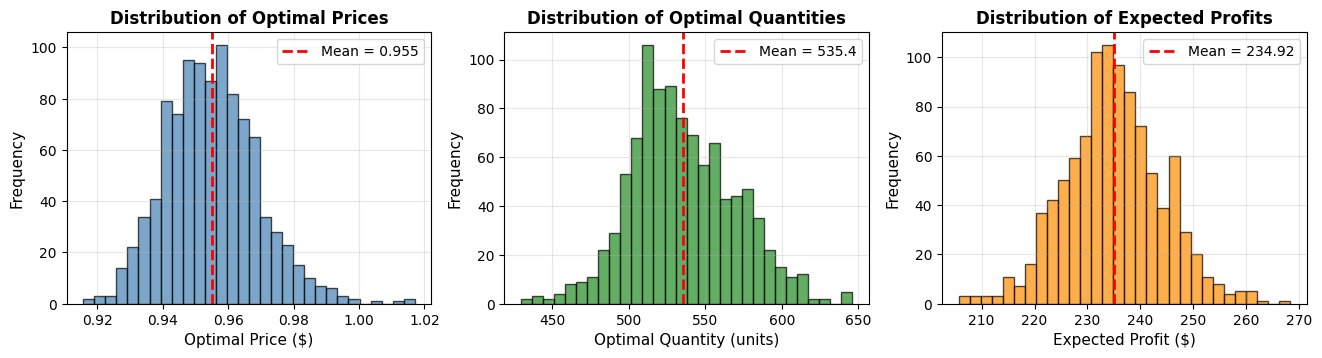

In [ ]:
# Step 7: Create visualizations

# Create comprehensive visualizations
fig = plt.figure(figsize=(16, 12))

# 1. Histogram of Optimal Prices
ax1 = plt.subplot(3, 3, 1)
plt.hist(bootstrap_results['prices'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
plt.axvline(np.mean(bootstrap_results['prices']), color='red', linestyle='--',
            linewidth=2, label=f'Mean = {np.mean(bootstrap_results["prices"]):.3f}')
plt.xlabel('Optimal Price ($)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Distribution of Optimal Prices', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# 2. Histogram of Optimal Quantities
ax2 = plt.subplot(3, 3, 2)
plt.hist(bootstrap_results['quantities'], bins=30, edgecolor='black', alpha=0.7, color='forestgreen')
plt.axvline(np.mean(bootstrap_results['quantities']), color='red', linestyle='--',
            linewidth=2, label=f'Mean = {np.mean(bootstrap_results["quantities"]):.1f}')
plt.xlabel('Optimal Quantity (units)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Distribution of Optimal Quantities', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# 3. Histogram of Expected Profits
ax3 = plt.subplot(3, 3, 3)
plt.hist(bootstrap_results['profits'], bins=30, edgecolor='black', alpha=0.7, color='darkorange')
plt.axvline(np.mean(bootstrap_results['profits']), color='red', linestyle='--',
            linewidth=2, label=f'Mean = {np.mean(bootstrap_results["profits"]):.2f}')
plt.xlabel('Expected Profit ($)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Distribution of Expected Profits', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

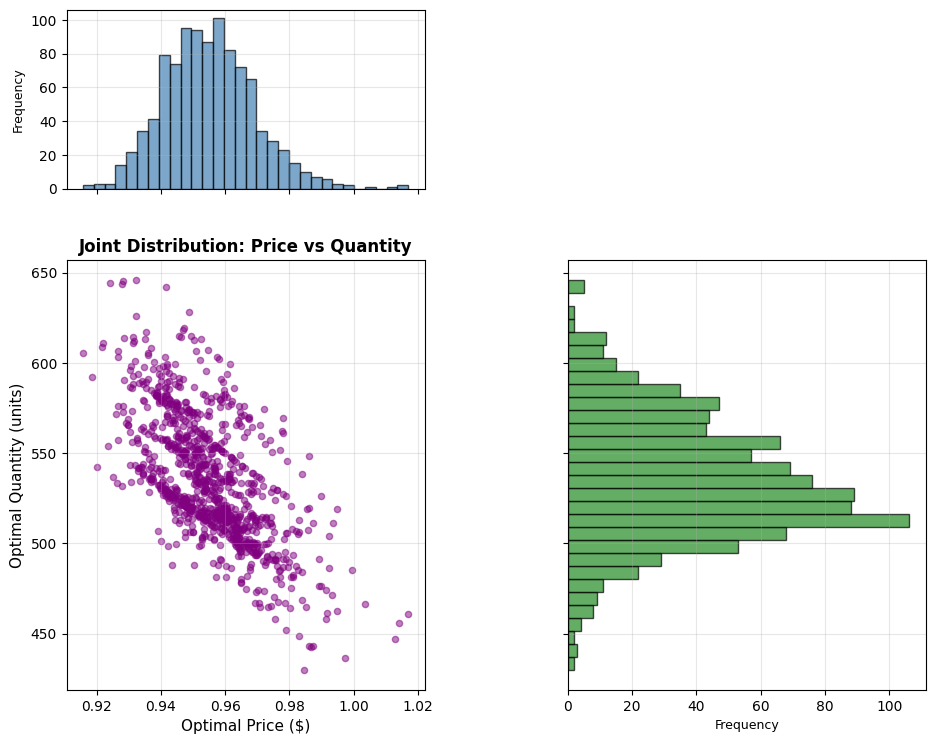

In [ ]:
# Scatterplot with marginal histograms (Price vs Quantity) (histograms on the x and y-axis as per instructions)
fig = plt.figure(figsize=(16, 8))

from matplotlib.gridspec import GridSpec

# Create grid for scatter plot with marginal histograms
gs = GridSpec(3, 3, figure=fig, left=0.1, right=0.95, bottom=0.1, top=0.95,
              wspace=0.4, hspace=0.4)

ax_scatter = fig.add_subplot(gs[1:, 0])
ax_hist_x = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
ax_hist_y = fig.add_subplot(gs[1:, 1], sharey=ax_scatter)

# Scatter plot
ax_scatter.scatter(bootstrap_results['prices'], bootstrap_results['quantities'],
                   alpha=0.5, s=20, color='purple')
ax_scatter.set_xlabel('Optimal Price ($)', fontsize=11)
ax_scatter.set_ylabel('Optimal Quantity (units)', fontsize=11)
ax_scatter.set_title('Joint Distribution: Price vs Quantity', fontsize=12, fontweight='bold')
ax_scatter.grid(alpha=0.3)

# Marginal histogram for price (top)
ax_hist_x.hist(bootstrap_results['prices'], bins=30, edgecolor='black',
               alpha=0.7, color='steelblue')
ax_hist_x.set_ylabel('Frequency', fontsize=9)
ax_hist_x.tick_params(labelbottom=False)
ax_hist_x.grid(alpha=0.3)

# Marginal histogram for quantity (right)
ax_hist_y.hist(bootstrap_results['quantities'], bins=30, orientation='horizontal',
               edgecolor='black', alpha=0.7, color='forestgreen')
ax_hist_y.set_xlabel('Frequency', fontsize=9)
ax_hist_y.tick_params(labelleft=False)
ax_hist_y.grid(alpha=0.3)